In [5]:
# -*- coding: utf-8 -*-

# @author: E.P. Based on code by Mohammad Asif Zaman

# Code for testng differentiation matrix operators

# Solves 𝛁²u(x,y) = f(x,y) 

# MIT License

# Copyright (c) 2020 Mohammad Asif Zaman

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.


In [98]:
from __future__ import print_function    

import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as py
import scipy.sparse as sp                 # import sparse matrix library
from scipy.sparse.linalg import spsolve

# Change math font style and general font size
py.rcParams['mathtext.fontset'] = 'stix'
# py.rcParams.update({'font.size': 14})


In [99]:
# Formato para mostrar equipotenciales.
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} V" if plt.rcParams["text.usetex"] else f"{s} V"

def Diff_mat_1D(Nx):
    # First derivative
    D_1d = sp.diags([-1, 1], [-1, 1], shape = (Nx,Nx)) # A division by (2*dx) is required later.
    D_1d = sp.lil_matrix(D_1d)
    D_1d[0,[0,1,2]] = [-3, 4, -1]               # this is 2nd order forward difference (2*dx division is required)
    D_1d[Nx-1,[Nx-3, Nx-2, Nx-1]] = [1, -4, 3]  # this is 2nd order backward difference (2*dx division is required)
    # Second derivative
    D2_1d =  sp.diags([1, -2, 1], [-1,0,1], shape = (Nx, Nx)) # division by dx^2 required
    D2_1d = sp.lil_matrix(D2_1d)                  
    D2_1d[0,[0,1,2,3]] = [2, -5, 4, -1]                    # this is 2nd order forward difference. division by dx^2 required. 
    D2_1d[Nx-1,[Nx-4, Nx-3, Nx-2, Nx-1]] = [-1, 4, -5, 2]  # this is 2nd order backward difference. division by dx^2 required.
    return D_1d, D2_1d

def Diff_mat_2D(Nx,Ny):
    # 1D differentiation matrices
    Dx_1d, D2x_1d = Diff_mat_1D(Nx)
    Dy_1d, D2y_1d = Diff_mat_1D(Ny)
    # Sparse identity matrices
    Ix = sp.eye(Nx)
    Iy = sp.eye(Ny)
    # 2D matrix operators from 1D operators using kronecker product
    # First partial derivatives
    Dx_2d = sp.kron(Iy,Dx_1d)
    Dy_2d = sp.kron(Dy_1d,Ix)
    # Second partial derivatives
    D2x_2d = sp.kron(Iy,D2x_1d)
    D2y_2d = sp.kron(D2y_1d,Ix)
    # Return compressed Sparse Row format of the sparse matrices
    return Dx_2d.tocsr(), Dy_2d.tocsr(), D2x_2d.tocsr(), D2y_2d.tocsr()

"""
@author: Mohammad Asif Zaman

Input arguments:
    1. x,y                        : Numpy array 1D. 1D independent spatial variables
    2. ub_o                       : Boundary values at the outer boundary regions (order left, right, top, bottom)
    3. B_type_o                   : Boundary type at the outer boundary region
    4. xb_i, yb_i                 : 1D numpy arrays defining internal rectangular regions with boundary conditions enforced
    5. ub_i                       : Boundary values at the inner boundary regions
    6. B_type_i                   : Boundary types at the inner boundary regions

Output arguments:
    1. B_ind                      : Python list. Each element of the list contains indices of a specific boundary region. 
                                    All boundary regions (outer and inner) are covered by this list.
    2. B_type                     : Python list/numpy array 1D. The boundary type of each boundary region.                                      
    3. B_val                      : Python list/numpy array 1D. The boundary value of each boundary region.
"""
def boundary_regions(x,y, ub_o,B_type_o, xb_i,yb_i,ub_i,B_type_i):
    
    boundary_indices = []
    boundary_type = []
    boundary_value = []
    
    # Create necessary meshgrid and unravel grid from x,y. Define Nx, Ny
    # =========================================================================
    X,Y = np.meshgrid(x,y)          # 2D meshgrid

    # 1D indexing
    Xu = X.ravel()                  # Unravel 2D meshgrid to 1D array
    Yu = Y.ravel()
    Nx = len(x)
    Ny = len(y)
    
    # =========================================================================
    
    # Finding outer boundary regions
    # =========================================================================
    
    ind_unravel_L = np.squeeze(np.where(Xu==x[0]))          # Left boundary
    ind_unravel_R = np.squeeze(np.where(Xu==x[Nx-1]))       # Right boundary
    ind_unravel_B = np.squeeze(np.where(Yu==y[0]))          # Bottom boundary
    ind_unravel_T = np.squeeze(np.where(Yu==y[Ny-1]))       # Top boundary
    
    # ind_boundary = np.where((X==x[0]) | (X==x[Nx-1]) | (Y==y[0]) | (Y==y[Ny-1]))    # outer boundary
    # ind_boundary_unravel = np.squeeze(np.where((Xu==x[0]) | (Xu==x[Nx-1]) | (Yu==y[0]) | (Yu==y[Ny-1])))  # outer boundaries 1D unravel indices
    
    boundary_indices.append(ind_unravel_L)
    boundary_indices.append(ind_unravel_R)
    boundary_indices.append(ind_unravel_T)
    boundary_indices.append(ind_unravel_B)
    
    boundary_type.extend(B_type_o)
    boundary_value.extend(ub_o)
    
    # =========================================================================
    
    # Finding inner boundary regions
    # =========================================================================
    Nb_i = len(ub_i)                # Number of inner boundary regions 
    
    # ind_boundary_i = []           # empty lists (initialization)
    # ind_boundary_i_unravel = []   # empty lists (initialization)
    for m in range(Nb_i):
        temp1 = np.squeeze(np.where((Xu>xb_i[m][0]) & (Xu<xb_i[m][1]) & (Yu>yb_i[m][0]) & (Yu<yb_i[m][1])))  # inner boundaries defined by xb_i and yb_i
        # temp2 = np.where((X>xb_i[m][0]) & (X<xb_i[m][1]) & (Y>yb_i[m][0]) & (Y<yb_i[m][1]))    #  inner boundaries    
        boundary_indices.append(temp1)
        # ind_boundary_i.append(temp2)
    
    boundary_type.extend(B_type_i)
    boundary_value.extend(ub_i)
    
    return boundary_indices,boundary_type,boundary_value

# Defining custom plotting functions
def my_contourf(x,y,F,ttl,clrmp = 'inferno'):
    cnt = py.contourf(x,y,F,41,cmap = clrmp)
    
    # Antialiasing block for exporting figure to pdf later
    for c in cnt.collections:
        c.set_edgecolor("face")
    
    cbar = py.colorbar()
    # py.xlabel(r'$x$',fontsize=26); py.ylabel(r'$y$',fontsize=26); 
    py.xlabel(r'$x$'); py.ylabel(r'$y$'); 
    # py.title(ttl)
    # cbar.set_label(ttl,fontsize=26)
    cbar.set_label(ttl)
    py.xlim([x[0],x[-1]])
    py.ylim([y[0],y[-1]])
    return 0
    

def my_scatter(x,y,clr,ttl=''):
    py.plot(x,y,'.',markersize=2,color=clr)
    # py.xlabel(r'$x$',fontsize=26); py.ylabel(r'$y$',fontsize = 26); py.title(ttl)
    py.xlabel(r'$x$'); py.ylabel(r'$y$'); py.title(ttl)
    return 0

# clr_set = ['#eaeee0','#ce9c9d','#adb5be','#57838d','#80adbc','#b4c9c7','#dadadc','#f3bfb3','#ccadb2','#445a67']

clr_set = []
for j in range(20):
    temp= ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
    clr_set.extend(temp)

clr_set[0] = '#eaeee0'

    

## Placas paralelas

Boundary search time = 0.0005


0

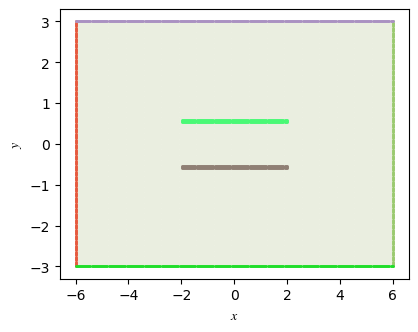

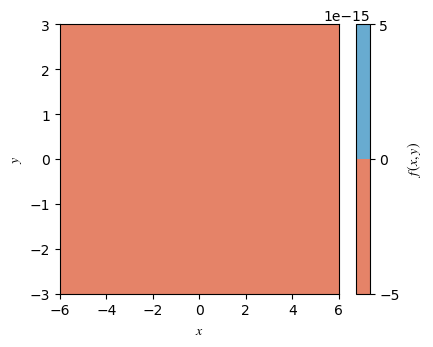

In [4]:
#===============================================================
# Dirichlet/Neumann boundary conditions at outerwalls (boundary 
# condition type is defined through boundary operators).
#===============================================================
uL = 0
uR = 0
uT = 0
uB = 0
ub_o = [uL, uR, uT, uB]
B_type_o = [1,1,2,2]    
# Type of outer boundary conditions.
# 0 = Dirichlet, 1 = Neumann x derivative, 2 = Neumann y derivative
# Order element 1 = left, element 2 = right, element 3 = top, element 4 = bottom
#===============================================================

#==============================================================================
# Dirichlet boundary conditions at an inner rectangular region
#==============================================================================

# Boundary defintion for the capacitor example
ub_i = [2,-2]                      # boundary values at inner region

xb_i = [[-2, 2],[-2, 2]]           # lower and upper limits of x defining the inner boundary region Format:[ [xlow1,xhigh1], [xlow2,xhigh2], .... ]
yb_i = [[.5,.6],[-.6, -.5]]        # lower and upper limits of y defining the inner boundary region Format:[ [ylow1,yhigh1], [ylow2,yhigh2], .... ]

Nb_i = len(ub_i)                   # Number of inner boundary regions
B_type_i = [0, 0]                  # Type of inner boundary conditions. 0 = Dirichlet, 1 = Neumann x derivative, 2 = Neumann y derivative. Note that setting inner boundaries to Neumann can lead to issues



# Boundary definitions for the diode example
# ub_i = [-2,2]                    # boundary values at inner region

# xb_i = [[-4,-3.8],[3.8,4]]       # lower and upper limits of x defining the inner boundary region Format:[ [xlow1,xhigh1], [xlow2,xhigh2], .... ]
# yb_i = [[-1,1],[-1,1]]           # lower and upper limits of y defining the inner boundary region Format:[ [ylow1,yhigh1], [ylow2,yhigh2], .... ]

# Nb_i = len(ub_i)                 # Number of inner boundary regions
# B_type_i = [0,0]                 # Type of inner boundary conditions. 0 = Dirichlet, 1 = Neumann. Note that setting inner boundaries to Neumann can lead to issues


# Boundary definition for the gravitational problem
# ub_i = []                   # boundary values at inner region

# xb_i = []                   # lower and upper limits of x defining the inner boundary region Format:[ [xlow1,xhigh1], [xlow2,xhigh2], .... ]
# yb_i = []                   # lower and upper limits of y defining the inner boundary region Format:[ [ylow1,yhigh1], [ylow2,yhigh2], .... ]

# Nb_i = len(ub_i)            # Number of inner boundary regions
# B_type_i = []  

#==============================================================================


#==============================================================================
# Define independent variables
#==============================================================================

Nx = 300                         # No. of grid points along x direction
Ny = 200                         # No. of grid points along y direction
x = np.linspace(-6,6,Nx)        # x variables in 1D
y = np.linspace(-3,3,Ny)        # y variable in 1D
#==============================================================================


dx = x[1] - x[0]                # grid spacing along x direction
dy = y[1] - y[0]                # grid spacing along y direction
X,Y = np.meshgrid(x,y)          # 2D meshgrid

# 1D indexing
Xu = X.ravel()                  # Unravel 2D meshgrid to 1D array
Yu = Y.ravel()

# Source function (right hand side vector)
f = np.zeros(Nx*Ny) 

# # Source term for the diode example
# for m in range(Nx*Ny):
#     if np.abs(Xu[m]) < 3.8 and np.abs(Yu[m])<1:
#         f[m] = -np.tanh(Xu[m])/np.cosh(Xu[m])

# Source term for the gravitational potential example
# for m in range(Nx*Ny):
#     if (Xu[m]-1.2)**2 + (Yu[m]+0.5)**2 < .3**2:
#         f[m] = .1
#     if (Xu[m]+1.2)**2 + (Yu[m]-1.5)**2 < .3**2:
#         f[m] = .05      

# Loading finite difference matrix operators

Dx_2d, Dy_2d, D2x_2d, D2y_2d = Diff_mat_2D(Nx,Ny)   # Calling 2D matrix operators from funciton

#//////////////////////////////////////////////////////////////////////////////

#==============================================================================
# Boundary indices
#==============================================================================

start_time = time.time()

# Find indices, types and value of all boundary regions
B_ind, B_type, B_val = boundary_regions(x,y, ub_o,B_type_o, xb_i,yb_i,ub_i,B_type_i)

N_B = len(B_val)    # Number of different boundary regions. Each region consists of one or more boundary points (usually many many points for a well defined solution grid)

print("Boundary search time = %1.6s" % (time.time()-start_time))


# Plot solution domain (with boundary)
py.close('all')
py.figure(figsize = (4.5,3.5))
my_scatter(X,Y,clr_set[0],'Solution grid')

for m in range(N_B):
    my_scatter(Xu[B_ind[m]], Yu[B_ind[m]],clr_set[m+1])

# Plot source function
py.figure(figsize = (4.5,3.5))
my_contourf(x,y,f.reshape(Ny,Nx),r'$f\,(x,y)$','RdBu')


In [5]:
#==============================================================================
# Construction of right hand vector (function of x and y)
#==============================================================================

start_time = time.time()

b = f
# Insert boundary values at the outer boundary points

for m in range(N_B):
    b[B_ind[m]] = B_val[m]


#============================================================================================
# Construction of the system matrix and adjust the right hand vector for boundary conditions
#============================================================================================

I_sp = sp.eye(Nx*Ny).tocsr()
L_sys = D2x_2d/dx**2 + D2y_2d/dy**2     # system matrix without boundary conditions

# Boundary operators
BD = I_sp       # Dirichlet boundary operator
BNx = Dx_2d     # Neumann boundary operator for x component
BNy = Dy_2d     # Neumann boundary operator for y component

# Selectively replace the rows of the system matrix that correspond to boundary value points. We replace these rows with 
# those of the boundary operator

for m in range(N_B):
    if B_type[m] == 0:
        L_sys[B_ind[m],:] = BD[B_ind[m],:]
    if B_type[m] == 1:
        L_sys[B_ind[m],:] = BNx[B_ind[m],:]
    if B_type[m] == 2:
        L_sys[B_ind[m],:] = BNy[B_ind[m],:]
        
print("System matrix and right hand vector computation time = %1.6s" % (time.time()-start_time)) 

System matrix and right hand vector computation time = 1.1625


In [6]:
# solve
start_time = time.time()
u = spsolve(L_sys,b).reshape(Ny,Nx)
print("spsolve() time = %1.6s" % (time.time()-start_time))
#==============================================================================

#==============================================================================
# Calculating the gradient of the solution
vx = -(Dx_2d*u.ravel()).reshape(Ny,Nx)
vy = -(Dy_2d*u.ravel()).reshape(Ny,Nx)
v = np.sqrt(vx**2 + vy**2)
#==============================================================================


spsolve() time = 0.5444


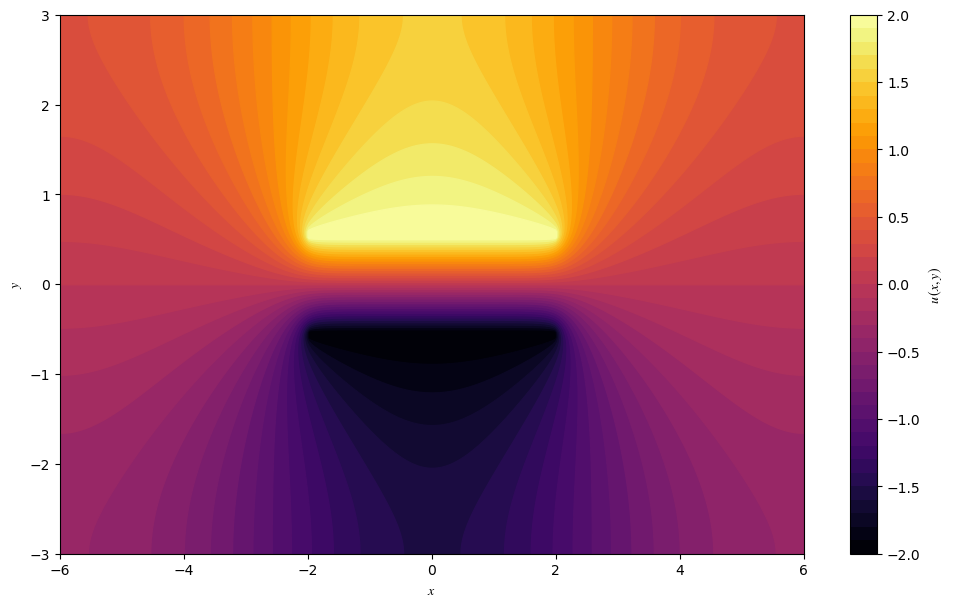

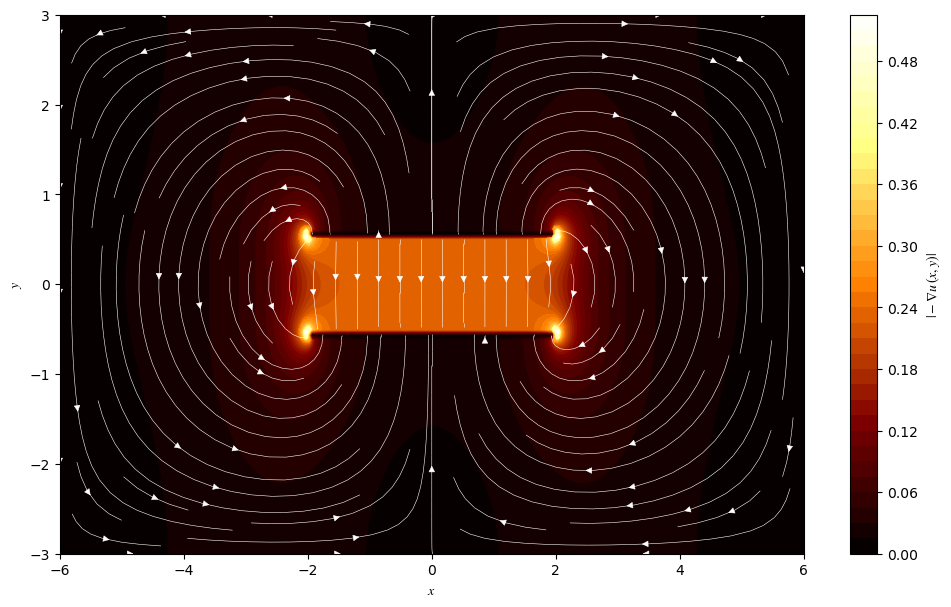

In [7]:
# Plot solution
py.figure(figsize = (12,7))
my_contourf(x,y,u,r'$u\,(x,y)$')

# Plotting the gradient
py.figure(figsize = (12,7))
my_contourf(x,y,v,r'$|-\nabla u\,(x,y)|$','afmhot')
py.streamplot(x,y,vx,vy,color = 'w',density = 1.2, linewidth = 0.4)

# thin_factor = 10
# skip = (slice(None, None, thin_factor), slice(None, None, thin_factor))
# py.quiver(X[skip],Y[skip],vx[skip]/v[skip],vy[skip]/v[skip],color = 'w')

## Un rectángulo

En la condiciones de borde externas, experimentar usando V=0 muy lejos, o cambiar a dV/dx=0 y dV/dy=0. ¿Cuál es el mejor enfoque para trabajar con regiones abiertas?

<Figure size 450x350 with 0 Axes>

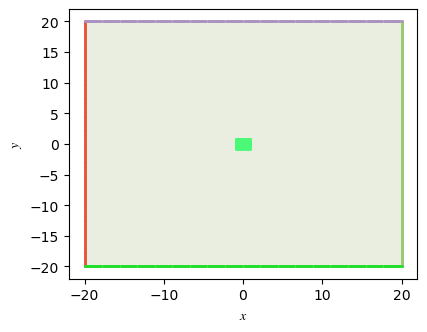

<Figure size 450x350 with 0 Axes>

In [23]:
#===============================================================
# Dirichlet/Neumann boundary conditions at outerwalls (boundary 
# condition type is defined through boundary operators).
#===============================================================
uL = 0
uR = 0
uT = 0
uB = 0
ub_o = [uL, uR, uT, uB]
B_type_o = [0,0,0,0]    
# Type of outer boundary conditions.
# 0 = Dirichlet, 1 = Neumann x derivative, 2 = Neumann y derivative
# Order element 1 = left, element 2 = right, element 3 = top, element 4 = bottom
#===============================================================

#==============================================================================
# Dirichlet boundary conditions at an inner rectangular region
#==============================================================================

# Boundary defintion for the capacitor example
ub_i = [12]                      # boundary values at inner region

xb_i = [[-1, 1]]           # lower and upper limits of x defining the inner boundary region Format:[ [xlow1,xhigh1], [xlow2,xhigh2], .... ]
yb_i = [[-1,1]]        # lower and upper limits of y defining the inner boundary region Format:[ [ylow1,yhigh1], [ylow2,yhigh2], .... ]

Nb_i = len(ub_i)                   # Number of inner boundary regions
B_type_i = [0]                  # Type of inner boundary conditions. 0 = Dirichlet, 1 = Neumann x derivative, 2 = Neumann y derivative. Note that setting inner boundaries to Neumann can lead to issues

#==============================================================================
# Define independent variables
#==============================================================================

Nx = 300                         # No. of grid points along x direction
Ny = 300                         # No. of grid points along y direction
x = np.linspace(-20,20,Nx)        # x variables in 1D
y = np.linspace(-20,20,Ny)        # y variable in 1D
#==============================================================================


dx = x[1] - x[0]                # grid spacing along x direction
dy = y[1] - y[0]                # grid spacing along y direction
X,Y = np.meshgrid(x,y)          # 2D meshgrid

# 1D indexing
Xu = X.ravel()                  # Unravel 2D meshgrid to 1D array
Yu = Y.ravel()

# Source function (right hand side vector)
f = np.zeros(Nx*Ny) 

# Loading finite difference matrix operators
Dx_2d, Dy_2d, D2x_2d, D2y_2d = Diff_mat_2D(Nx,Ny)   # Calling 2D matrix operators from funciton

# Find indices, types and value of all boundary regions
B_ind, B_type, B_val = boundary_regions(x,y, ub_o,B_type_o, xb_i,yb_i,ub_i,B_type_i)

N_B = len(B_val)    # Number of different boundary regions. Each region consists of one or more boundary points (usually many many points for a well defined solution grid)

# Plot solution domain (with boundary)
py.close('all')
py.figure(figsize = (4.5,3.5))
my_scatter(X,Y,clr_set[0],'Solution grid')

for m in range(N_B):
    my_scatter(Xu[B_ind[m]], Yu[B_ind[m]],clr_set[m+1])

# Plot source function
py.figure(figsize = (4.5,3.5))
# my_contourf(x,y,f.reshape(Ny,Nx),r'$f\,(x,y)$','RdBu')


In [24]:
#==============================================================================
# Construction of right hand vector (function of x and y)
#==============================================================================

start_time = time.time()

b = f
# Insert boundary values at the outer boundary points

for m in range(N_B):
    b[B_ind[m]] = B_val[m]

#============================================================================================
# Construction of the system matrix and adjust the right hand vector for boundary conditions
#============================================================================================

I_sp = sp.eye(Nx*Ny).tocsr()
L_sys = D2x_2d/dx**2 + D2y_2d/dy**2     # system matrix without boundary conditions

# Boundary operators
BD = I_sp       # Dirichlet boundary operator
BNx = Dx_2d     # Neumann boundary operator for x component
BNy = Dy_2d     # Neumann boundary operator for y component

# Selectively replace the rows of the system matrix that correspond to boundary value points. We replace these rows with 
# those of the boundary operator

for m in range(N_B):
    if B_type[m] == 0:
        L_sys[B_ind[m],:] = BD[B_ind[m],:]
    if B_type[m] == 1:
        L_sys[B_ind[m],:] = BNx[B_ind[m],:]
    if B_type[m] == 2:
        L_sys[B_ind[m],:] = BNy[B_ind[m],:]
        
print("System matrix and right hand vector computation time = %1.6s" % (time.time()-start_time)) 

# solve
start_time = time.time()
u = spsolve(L_sys,b).reshape(Ny,Nx)
print("spsolve() time = %1.6s" % (time.time()-start_time))
#==============================================================================

#==============================================================================
# Calculating the gradient of the solution
vx = -(Dx_2d*u.ravel()).reshape(Ny,Nx)
vy = -(Dy_2d*u.ravel()).reshape(Ny,Nx)
v = np.sqrt(vx**2 + vy**2)
#==============================================================================

System matrix and right hand vector computation time = 1.7711
spsolve() time = 0.9073


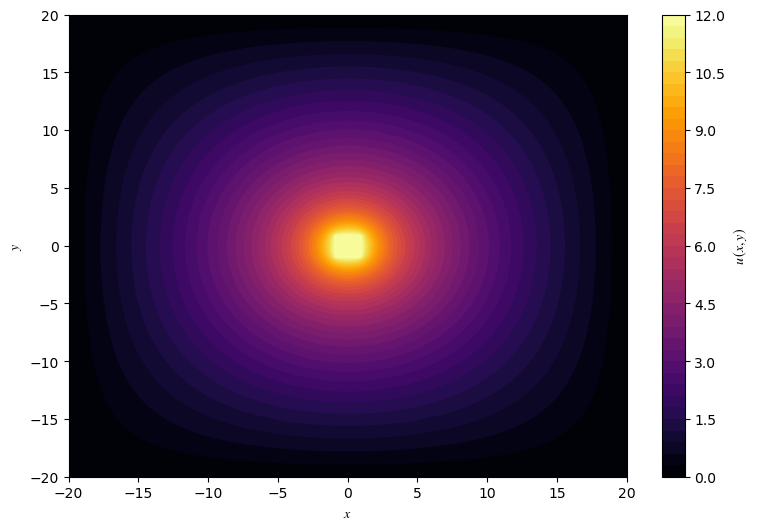

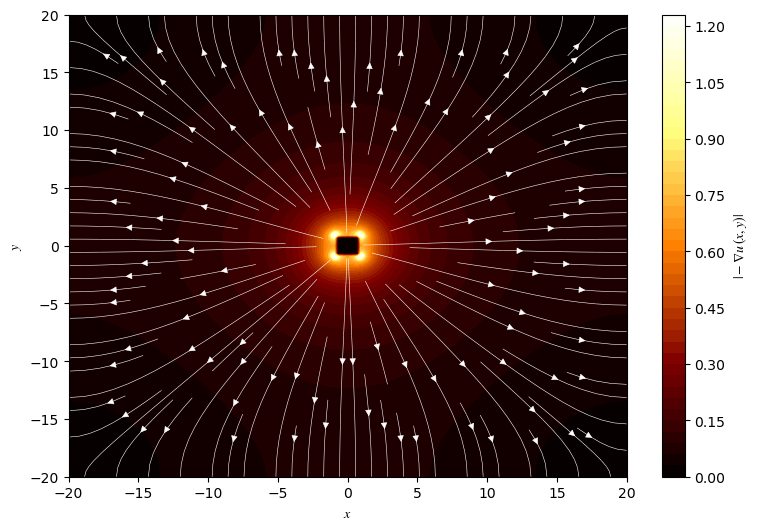

In [25]:
# Plot solution
py.figure(figsize = (9,6))
my_contourf(x,y,u,r'$u\,(x,y)$')

# Plotting the gradient
py.figure(figsize = (9,6))
my_contourf(x,y,v,r'$|-\nabla u\,(x,y)|$','afmhot')
py.streamplot(x,y,vx,vy,color = 'w',density = 1.2, linewidth = 0.4)

## Una esfera

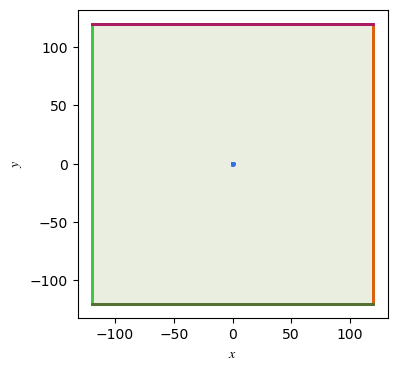

In [95]:
#===============================================================
# Dirichlet/Neumann boundary conditions at outerwalls (boundary 
# condition type is defined through boundary operators).
#===============================================================
uL = 0
uR = 0
uT = 0
uB = 0
ub_o = [uL, uR, uT, uB]
B_type_o = [1,1,2,2]    
# Type of outer boundary conditions.
# 0 = Dirichlet, 1 = Neumann x derivative, 2 = Neumann y derivative
# Order element 1 = left, element 2 = right, element 3 = top, element 4 = bottom
#===============================================================

#==============================================================================
# Dirichlet boundary conditions at an inner rectangular region
#==============================================================================

ub_i = []                      # boundary values at inner region

xb_i = []           # lower and upper limits of x defining the inner boundary region Format:[ [xlow1,xhigh1], [xlow2,xhigh2], .... ]
yb_i = []        # lower and upper limits of y defining the inner boundary region Format:[ [ylow1,yhigh1], [ylow2,yhigh2], .... ]

Nb_i = len(ub_i)                   # Number of inner boundary regions
B_type_i = []                  # Type of inner boundary conditions. 0 = Dirichlet, 1 = Neumann x derivative, 2 = Neumann y derivative. Note that setting inner boundaries to Neumann can lead to issues

#==============================================================================
# Define independent variables
#==============================================================================

Nx = 1000                         # No. of grid points along x direction
Ny = 1000                        # No. of grid points along y direction
x = np.linspace(-120,120,Nx)        # x variables in 1D
y = np.linspace(-120,120,Ny)        # y variable in 1D
#==============================================================================


dx = x[1] - x[0]                # grid spacing along x direction
dy = y[1] - y[0]                # grid spacing along y direction
X,Y = np.meshgrid(x,y)          # 2D meshgrid

# 1D indexing
Xu = X.ravel()                  # Unravel 2D meshgrid to 1D array
Yu = Y.ravel()

# Source function (right hand side vector)
f = np.zeros(Nx*Ny) 

# Loading finite difference matrix operators
Dx_2d, Dy_2d, D2x_2d, D2y_2d = Diff_mat_2D(Nx,Ny)   # Calling 2D matrix operators from funciton

# Find indices, types and value of all boundary regions
B_ind, B_type, B_val = boundary_regions(x,y, ub_o,B_type_o, xb_i,yb_i,ub_i,B_type_i)

# Esfera:
temp1 = np.squeeze(np.where((Xu-0)**2+(Yu-0)**2 <= 1**2))
B_ind.append(temp1)
B_type.append(0)
B_val.append(12)

N_B = len(B_val)    # Number of different boundary regions. Each region consists of one or more boundary points (usually many many points for a well defined solution grid)

# Plot solution domain (with boundary)
py.close('all')
py.figure(figsize = (4,4))
my_scatter(X,Y,clr_set[0],'Solution grid')

for m in range(N_B):
    my_scatter(Xu[B_ind[m]], Yu[B_ind[m]],clr_set[m+1])

# Plot source function
# py.figure(figsize = (4.5,3.5))
# my_contourf(x,y,f.reshape(Ny,Nx),r'$f\,(x,y)$','RdBu')

In [96]:
start_time = time.time()
b = f
for m in range(N_B):
    b[B_ind[m]] = B_val[m]

I_sp = sp.eye(Nx*Ny).tocsr()
L_sys = D2x_2d/dx**2 + D2y_2d/dy**2 
BD = I_sp
BNx = Dx_2d
BNy = Dy_2d
for m in range(N_B):
    if B_type[m] == 0:
        L_sys[B_ind[m],:] = BD[B_ind[m],:]
    if B_type[m] == 1:
        L_sys[B_ind[m],:] = BNx[B_ind[m],:]
    if B_type[m] == 2:
        L_sys[B_ind[m],:] = BNy[B_ind[m],:]
        
# solve
u = spsolve(L_sys,b).reshape(Ny,Nx)
print("spsolve() time = %1.6s" % (time.time()-start_time))
# Calculating the gradient of the solution
vx = -(Dx_2d*u.ravel()).reshape(Ny,Nx)
vy = -(Dy_2d*u.ravel()).reshape(Ny,Nx)
v = np.sqrt(vx**2 + vy**2)

spsolve() time = 111.83


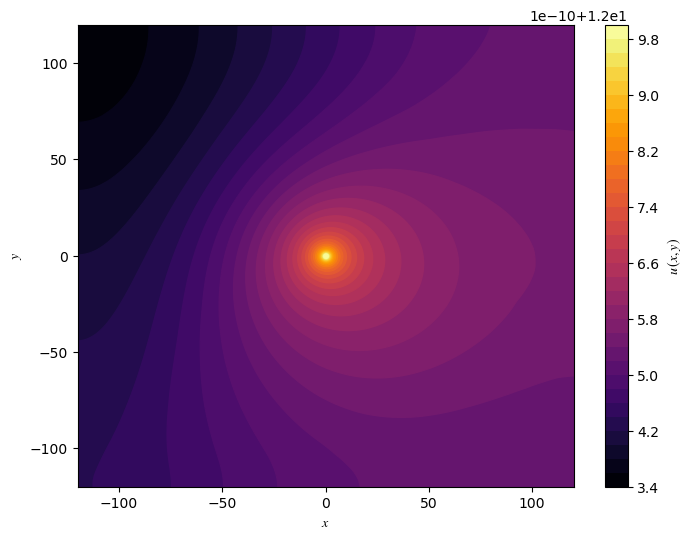

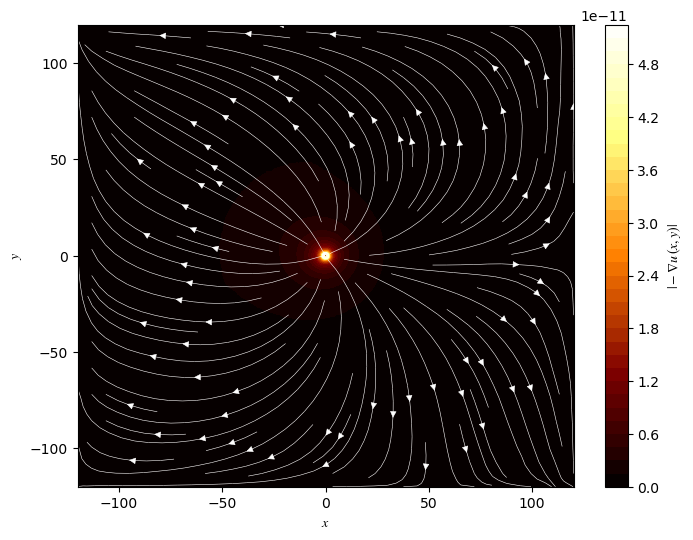

In [97]:
# Plot solution
py.figure(figsize = (8,6))
my_contourf(x,y,u,r'$u\,(x,y)$')

# Plotting the gradient
py.figure(figsize = (8,6))
my_contourf(x,y,v,r'$|-\nabla u\,(x,y)|$','afmhot')
py.streamplot(x,y,vx,vy,color = 'w',density = 1.2, linewidth = 0.4)

TypeError: Input z must be 2D, not 1D

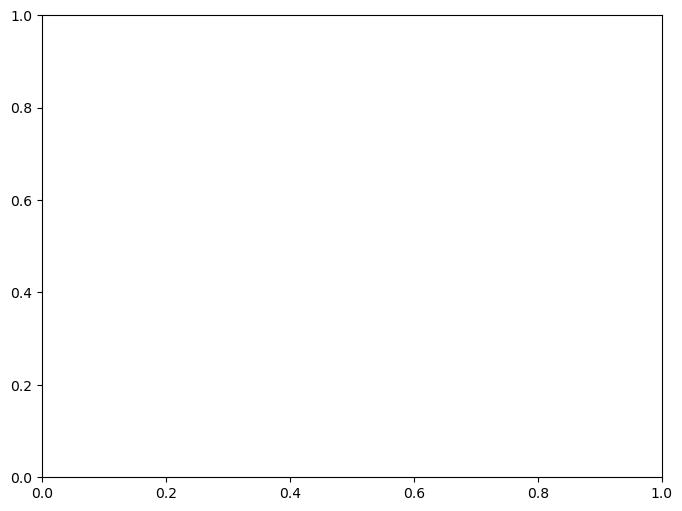

In [100]:
# Potencial Exacto: se asume la carga total en el centro.
D = np.sqrt(np.power(Xu, 2) + np.power(Yu, 2))
Vexacto = 12 / D
# Plot solution
py.figure(figsize = (8,6))
my_contourf(x,y,Vexacto,r'$u\,(x,y)$')

